<a href="https://colab.research.google.com/github/Shaman1266/degin/blob/master/Copy_of_Imbalance_shift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Скачиваем датасет, подключаем библиотеки

In [0]:
!mkdir /root/.kaggle
!echo '{"username":"","key":""}' > /root/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

 86% 57.0M/66.0M [00:00<00:00, 49.7MB/s]
100% 66.0M/66.0M [00:00<00:00, 84.8MB/s]


In [0]:
!unzip -qq /content/creditcardfraud.zip

In [0]:
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn import metrics, ensemble, tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing


import matplotlib.pyplot as plt
import itertools

## Посмотрим на данные

Данный датасет о транзакциях с кредитных карт. Основня цель - найти мошенические операции. *Чистые* данные только о времени и сумме, остальные трансформированы с помощью PCA.

In [0]:
data = pd.read_csv('/content/creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [0]:
all(data.isnull().any())

False

Как можно увидеть данные очень несбалансированы. Данная проблема очень чувствительна в методах машинного обучения. Посылая такую выборку в обучения, метод смещается в сторону большего класса и мы получаем на нем более хорошую точность предсказания,в ущерб меньшего.

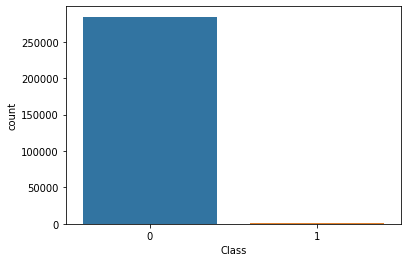

In [0]:
sns.countplot('Class', data=data)

In [0]:
print('Нормальных транзакций:',len(data[data['Class']==0]))
print('Мошеннических транзакций:',len(data[data['Class']==1]))
print('Малый класс:',len(data[data['Class']==1])/len(data)*100,'%')

Нормальных транзакций: 284315
Мошеннических транзакций: 492
Малый класс: 0.1727485630620034 %


In [0]:
y = data['Class']

In [0]:
# нормализуем данные.Время и сумма у нас в таблице как есть
data['Normalized Amount'] = preprocessing.StandardScaler().fit_transform(np.array(data['Amount']).reshape(-1, 1))
data['Normalized Time'] = preprocessing.StandardScaler().fit_transform(np.array(data['Time']).reshape(-1, 1))
data.drop(['Amount','Time','Class'],axis=1,inplace=True)

In [0]:
X = data

In [0]:
X

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Normalized Amount,Normalized Time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,-1.996562
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,-1.996562
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,-1.996541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,-0.350151,1.641931
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,-0.254117,1.641952
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,-0.081839,1.641974
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,-0.313249,1.641974


In [0]:
y

0         0
1         0
2         0
3         0
4         0
         ..
284802    0
284803    0
284804    0
284805    0
284806    0
Name: Class, Length: 284807, dtype: int64

## Используемуе метрики, а так же функции обучения

Для того, чтобы точно интерпретировать результаты обучения, простой точности недостаточно в дизбалансе классов. Поэтому будем использовать матрицу ошибок, а так же.
Из метрик:

1.   Матрица ошибок
2.   precision (TP / (TP + FP)) 
3.   recall (TP / (TP + FN))
4.   f1-score (F1 = 2 * (precision * recall) / (precision + recall))

В основном будем смотреть на F1-score

In [0]:
from sklearn.metrics import confusion_matrix, ,classification_report 
from sklearn.model_selection import RandomizedSearchCV

In [0]:
def train(x_train, y_train):
  '''Поиск лучших параметров очень дорогозатратная по времени процедура.Так что была
  запущена один раз.С изменением выборки это уже могут быть не лучшие параметрами.'''

  log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
  knears_params = {"n_neighbors": list(range(2,4,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
  tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(4,8,2)),"min_samples_leaf": list(range(5,7,1))}

  search_log = RandomizedSearchCV(LogisticRegression(n_jobs=-1, solver='liblinear') ,log_reg_params)
  search_log.fit(x_train, y_train)

  search_knn = RandomizedSearchCV(KNeighborsClassifier(n_jobs=-1, ) ,
                                  knears_params)
  search_knn.fit(x_train, y_train)

  search_tree = RandomizedSearchCV(ensemble.RandomForestClassifier(n_estimators=100, 
                                                                   n_jobs=-1) ,tree_params)
  search_tree.fit(x_train, y_train)
  return search_log.best_estimator_, search_knn.best_estimator_, search_tree.best_estimator_

def train_no_best(x_train, y_train):
  log = LogisticRegression(C=100, class_weight=None,  n_jobs=-1, penalty='l1',
                           solver='liblinear')
  log.fit(x_train, y_train)

  knn = KNeighborsClassifier(algorithm='kd_tree', n_jobs=-1, n_neighbors=3, 
                             weights='uniform')
  knn.fit(x_train, y_train)

  tree = ensemble.RandomForestClassifier(class_weight=None,criterion='entropy', 
                                         max_depth=6, n_estimators=100,n_jobs=-1, )
  tree.fit(x_train, y_train)
  return log, knn, tree

def pred(log, knn, tree, x_test, y_test):
  cm = []
  predict = log.predict(x_test)
  print('Logistic Regression \n', metrics.classification_report(y_test, predict), 
        '____________________________')
  cm.append((predict,y_test))

  predict = knn.predict(x_test)
  print('KN  Classifier \n', metrics.classification_report(y_test, predict),
  '____________________________')
  cm.append((predict,y_test))

  predict = tree.predict(x_test)
  print('Random Forest Classifier \n',metrics.classification_report(y_test, predict),
  '____________________________')
  cm.append((predict,y_test))

  met(cm)
  

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def met(cm):
  fig = plt.figure(figsize=(12,8))

  fig.add_subplot(231)
  cnf_matrix = confusion_matrix(cm[0][0],cm[0][1])
  plot_confusion_matrix(cnf_matrix, ['0','1'] ,title="Logistic Regression \n Confusion Matrix", cmap=plt.cm.Reds)

  fig.add_subplot(232)
  cnf_matrix = confusion_matrix(cm[1][0],cm[1][1])
  plot_confusion_matrix(cnf_matrix, ['0','1'], title="KNeighbors Classifier \n Confusion Matrix", cmap=plt.cm.Greens )

  fig.add_subplot(233)
  cnf_matrix = confusion_matrix(cm[2][0],cm[2][1])
  plot_confusion_matrix(cnf_matrix, ['0','1'], title="Random Forest Classifier \n Confusion Matrix", cmap=plt.cm.Blues )

## Обучаем без вмешательство в выборку

In [0]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [0]:
log, knn, tree = train_no_best(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Logistic Regression 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.64      0.73        98

    accuracy                           1.00     56962
   macro avg       0.93      0.82      0.87     56962
weighted avg       1.00      1.00      1.00     56962
 ____________________________
KN  Classifier 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.71      0.82        98

    accuracy                           1.00     56962
   macro avg       0.98      0.86      0.91     56962
weighted avg       1.00      1.00      1.00     56962
 ____________________________
Random Forest Classifier 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.70      0.81        98

    accuracy                           1.00     56962
   m

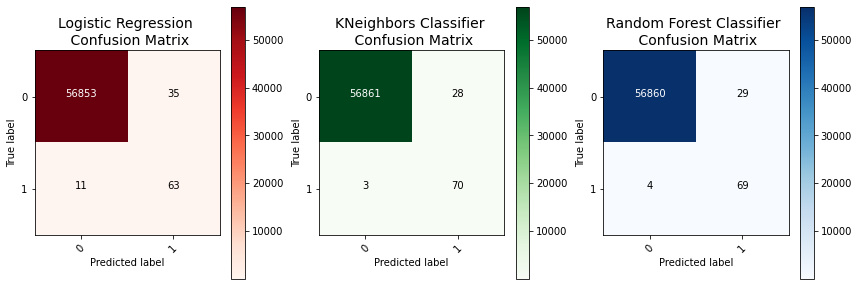

In [0]:
pred(log, knn, tree, x_test, y_test)

Как видим лучший результат до борьбы с дизбалансом - у KN f1-0.82

## Вмешаемся

Какие мы можем себе позволить методы борьбы с дизбалансом классов?

1.   Собрать еще данных.(не можем)
2.   Продублировать данные меньшего класса
3.   Урезать данные преобладающего класса
4.   Штрафовать веса моделей при обучении на преобладающем классе



Для начала расширим меньший класс просто продублировав его

In [0]:
high_to_add = x_train[y_train.values == 1].shape[0]
size_to_add = np.sum(y_train == 0) - np.sum(y_train == 1) 

In [0]:
np.random.seed(0)
indices_to_add = np.random.randint(low=0, high=high_to_add, size = size_to_add)

In [0]:
x_train = x_train.to_numpy()

In [0]:
X_train_to_add = x_train[y_train.values == 1][indices_to_add, :]

In [0]:
X_train_to_add = np.vstack((x_train, X_train_to_add))
y_train_to_add = np.hstack((y_train,np.ones((size_to_add,))))

In [0]:
print('Класс 0:',len(y_train_to_add[y_train_to_add == 0]))
print('Класс 1:',len(y_train_to_add[y_train_to_add == 1]))
print('Всего:', X_train_to_add.shape[0])

Класс 0: 227451
Класс 1: 227451
Всего: 454902


In [0]:
log, knn, tree = train_no_best(X_train_to_add, y_train_to_add)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Logistic Regression 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.88      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.93      0.55     56962
weighted avg       1.00      0.98      0.99     56962
 ____________________________
KN  Classifier 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.81      0.82        98

    accuracy                           1.00     56962
   macro avg       0.92      0.90      0.91     56962
weighted avg       1.00      1.00      1.00     56962
 ____________________________
Random Forest Classifier 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.49      0.84      0.61        98

    accuracy                           1.00     56962
   m

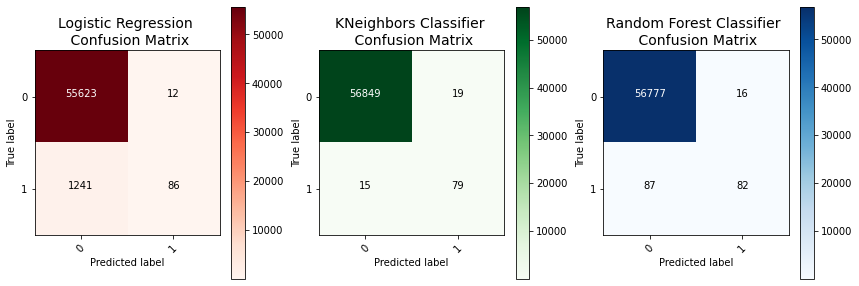

In [0]:
pred(log, knn, tree, x_test, y_test)

Хоть f1-score не улучшился, но нам удалось перехватить больше мошенических операций в KN при относительно малых потерях.Попробуем не просто добавить, а реализуем через imblearn методом SMOTE

In [0]:
pip install -U imbalanced-learn

     |████████████████████████████████| 163kB 5.0MB/s 
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


In [0]:
from imblearn.over_sampling import SMOTE

In [0]:
sm = SMOTE()
X_train_to_add, y_train_to_add = sm.fit_sample(x_train, y_train)

In [0]:
print('Класс 0:',len(y_train_to_add[y_train_to_add == 0]))
print('Класс 1:',len(y_train_to_add[y_train_to_add == 1]))
print('Всего:', X_train_to_add.shape[0])

Класс 0: 227451
Класс 1: 227451
Всего: 454902


In [0]:
log, knn, tree = train_no_best(X_train_to_add, y_train_to_add)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Logistic Regression 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.89      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.93      0.55     56962
weighted avg       1.00      0.98      0.99     56962
 ____________________________
KN  Classifier 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.57      0.83      0.67        98

    accuracy                           1.00     56962
   macro avg       0.79      0.91      0.84     56962
weighted avg       1.00      1.00      1.00     56962
 ____________________________
Random Forest Classifier 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.40      0.85      0.54        98

    accuracy                           1.00     56962
   m

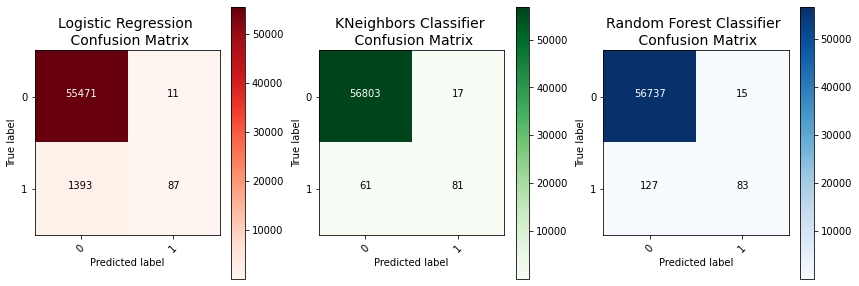

In [0]:
pred(log, knn, tree, x_test, y_test)

Пока улучшений нет.Теперь попробуем уменьшить преобладающий класс.

In [0]:
from imblearn.under_sampling import NearMiss

In [0]:
nm = NearMiss( )
X_train_to_add, y_train_to_add = nm.fit_resample(x_train, y_train)

In [0]:
print('Класс 0:',len(y_train_to_add[y_train_to_add == 0]))
print('Класс 1:',len(y_train_to_add[y_train_to_add == 1]))
print('Всего:', X_train_to_add.shape[0])

Класс 0: 394
Класс 1: 394
Всего: 788


In [0]:
log, knn, tree = train_no_best(X_train_to_add, y_train_to_add)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Logistic Regression 
               precision    recall  f1-score   support

           0       1.00      0.49      0.66     56864
           1       0.00      0.90      0.01        98

    accuracy                           0.49     56962
   macro avg       0.50      0.70      0.33     56962
weighted avg       1.00      0.49      0.66     56962
 ____________________________
KN  Classifier 
               precision    recall  f1-score   support

           0       1.00      0.64      0.78     56864
           1       0.00      0.88      0.01        98

    accuracy                           0.64     56962
   macro avg       0.50      0.76      0.39     56962
weighted avg       1.00      0.64      0.78     56962
 ____________________________
Random Forest Classifier 
               precision    recall  f1-score   support

           0       1.00      0.10      0.18     56864
           1       0.00      0.96      0.00        98

    accuracy                           0.10     56962
   m

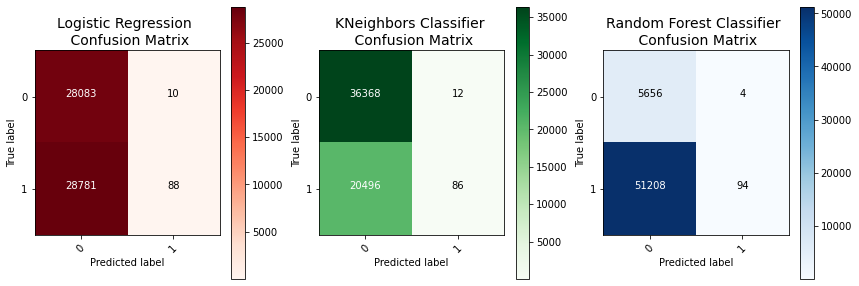

In [0]:
pred(log, knn, tree, x_test, y_test)

С таким небольшим классом было бы удивительно, если бы у нас что-то получилось.Попробуй еще один комбинированный метод 

In [0]:
from imblearn.combine import SMOTETomek

In [0]:
st = SMOTETomek()
X_train_to_add, y_train_to_add = st.fit_resample(x_train, y_train)

In [0]:
print('Класс 0:',len(y_train_to_add[y_train_to_add == 0]))
print('Класс 1:',len(y_train_to_add[y_train_to_add == 1]))
print('Всего:', X_train_to_add.shape[0])

Класс 0: 227451
Класс 1: 227451
Всего: 454902


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Logistic Regression 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.89      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.93      0.55     56962
weighted avg       1.00      0.98      0.99     56962
 ____________________________
KN  Classifier 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.57      0.83      0.67        98

    accuracy                           1.00     56962
   macro avg       0.79      0.91      0.84     56962
weighted avg       1.00      1.00      1.00     56962
 ____________________________
Random Forest Classifier 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.40      0.86      0.55        98

    accuracy                           1.00     56962
   m

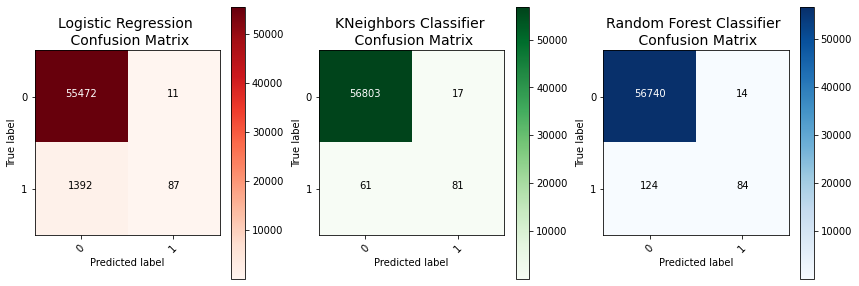

In [0]:
log, knn, tree = train_no_best(X_train_to_add, y_train_to_add)
pred(log, knn, tree, x_test, y_test)

Попробуем теперь штрафовать алгоритмы

In [0]:
log = LogisticRegression(C=100, class_weight='balanced',  n_jobs=-1, penalty='l1',solver='liblinear')
log.fit(x_train, y_train)
knn = KNeighborsClassifier(algorithm='kd_tree', n_jobs=-1, n_neighbors=3,weights='distance')
knn.fit(x_train, y_train)
tree = ensemble.RandomForestClassifier(class_weight='balanced',criterion='entropy',max_depth=6, n_estimators=100,n_jobs=-1, )
tree.fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

Logistic Regression 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.88      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.93      0.56     56962
weighted avg       1.00      0.98      0.99     56962
 ____________________________
KN  Classifier 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.71      0.82        98

    accuracy                           1.00     56962
   macro avg       0.98      0.86      0.91     56962
weighted avg       1.00      1.00      1.00     56962
 ____________________________
Random Forest Classifier 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.66      0.82      0.73        98

    accuracy                           1.00     56962
   m

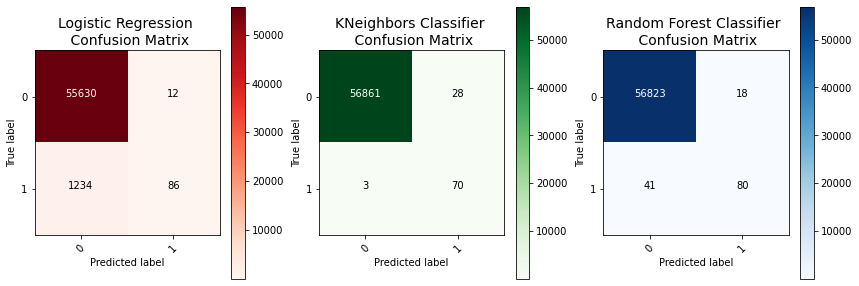

In [0]:
pred(log, knn, tree, x_test, y_test)

Как можно посмотреть, приемлемый результат получился при расширении меньшего класса.И это далеко не предел.Можно попробовать другие алгоритмы, перебрать лучшие параметры для них.Но такой задачи не было :3. На данном этапе задачу с дизбалансом считаю выполненной